In [ ]:
!pip install tensorflow_ranking
!pip install tf2onnx
!pip install adversarial-robustness-toolbox
!pip uninstall numpy
!pip install numpy==1.23.5

In [1]:
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Dense, Reshape, Activation, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.initializers import GlorotUniform
import tensorflow as tf
import tensorflow_ranking as tfr
import tf2onnx
import numpy as np
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent

In [2]:
import sys
sys.path.append(sys.path.append('/content/drive/My Drive/CURIS/VeriX/train_networks'))

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
tf.compat.v1.disable_eager_execution()

In [5]:
SEED = 137
output_path = 'drive/MyDrive/CURIS/VeriX/networks/'

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

11490434/11490434 [==============================] - 2s 0us/step


In [8]:
import matplotlib.pyplot as plt
def plot_figure(image, path=None, cmap=None):
    fig = plt.figure()
    ax = plt.Axes(fig, [-0.5, -0.5, 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.imshow(image, cmap=cmap)
    if path is not None:
      plt.savefig(path, bbox_inches='tight')
    # plt.close(fig)

In [7]:
def eval_and_save(model):
  score = model.evaluate(x_test, y_test, verbose=0)
  print("Test loss:", score[0])
  print("Test accuracy:", score[1])
  model.summary()
  model.save(output_path + model.name + '.h5')
  # model_proto, _ = tf2onnx.convert.from_keras(model, output_path=output_path + model.name + '.onnx')

In [8]:
def print_weights(model):
  for layer in model.layers:
    print(layer.get_config())
    print(layer.get_weights())

In [9]:
def train_pgd(model_pgd, num_epochs, alpha):
  art_model_pgd = KerasClassifier(model_pgd, clip_values=(0, 1))
  art_model_pgd.fit(x_train, y_train,
              batch_size=128,
              nb_epochs=1,
              verbose=1,
              validation_data=(x_test, y_test))
  pgd_attack = ProjectedGradientDescent(art_model_pgd, eps=0.1, eps_step=0.01, max_iter=10, verbose=False)

  num_samples = len(x_train)
  num_adv = int(num_samples * alpha)
  num_real = num_samples - num_adv

  for i in range(num_epochs - 1):
    adv_indices = np.random.choice(x_train.shape[0], size=num_adv, replace=False)
    real_indices = np.random.choice(x_train.shape[0], size=num_real, replace=False)
    adv_samples = pgd_attack.generate(
        x_train[adv_indices],
        batch_size=128)
    x_real = x_train[real_indices]
    y_real = y_train[real_indices]
    x_adv = np.concatenate((adv_samples, x_real))
    y_adv = np.concatenate((y_train[adv_indices], y_real))
    permutation = np.random.permutation(num_samples)
    x_adv = x_adv[permutation]
    y_adv = y_adv[permutation]
    art_model_pgd.fit(x_adv, y_adv,
              batch_size=128,
              nb_epochs=1,
              verbose=1,
              validation_data=(x_test, y_test))
    score = model_pgd.evaluate(adv_samples, y_train[adv_indices])
    print(f'adv train loss: {score[0]} train acc: {score[1]}')

In [10]:
def evaluate(model, model_adv):
  print('Test loss and accuracy on original test data:')
  print('Regular model:')
  print(model.evaluate(x_test, y_test))
  print('Adv model:')
  print(model_adv.evaluate(x_test, y_test))
  print('')

  print('Test loss and accuracy on adv samples from regular model:')
  art_model_regular_pgd = KerasClassifier(model, clip_values=(0, 1))
  # pgd_attack_regular = ProjectedGradientDescent(art_model_regular_pgd, eps=0.1, eps_step=0.01, max_iter=50, verbose=False)
  # adv = pgd_attack_regular.generate(x_test, batch_size=128)
  fgm_attack_regular = FastGradientMethod(art_model_regular_pgd)
  adv = fgm_attack_regular.generate(x_test, batch_size=128)
  print('Regular model:')
  print(model.evaluate(adv, y_test))
  print('Adv model:')
  print(model_adv.evaluate(adv, y_test))
  print('')

  print('Test loss and accuracy on adv samples from adv model:')
  art_model_adv_pgd = KerasClassifier(model_adv, clip_values=(0, 1))
  # pgd_attack_adv = ProjectedGradientDescent(art_model_adv_pgd, eps=0.1, eps_step=0.01, max_iter=50, verbose=False)
  # adv = pgd_attack_adv.generate(x_test, batch_size=128)
  fgm_attack_adv = FastGradientMethod(art_model_adv_pgd)
  adv = fgm_attack_adv.generate(x_test, batch_size=128)
  print('Regular model:')
  print(model.evaluate(adv, y_test))
  print('Adv model:')
  print(model_adv.evaluate(adv, y_test))

10x2 fully connected

In [12]:
num_epochs = 20
alpha = 0.5 # proportion of adv samples

In [13]:
# normally trained model for compariaon
inputs = Input(shape=(28, 28, 1))
x = Flatten()(inputs)
x = Dense(10, name='dense_1', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dense(10, name='dense_2', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
outputs = Dense(10, name='logit', activation='softmax', kernel_initializer=GlorotUniform(seed=SEED))(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist-10x2-normal')
model.compile(loss='categorical_crossentropy',
              # loss=tf.keras.losses.CategoricalCrossentropy(),
              # loss=tfr.keras.losses.SoftmaxLoss(),
              optimizer=keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=128,
          epochs=num_epochs,
          verbose=0,
          validation_data=(x_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


In [59]:
# model for adversarial training with pgd
inputs = Input(shape=(28, 28, 1))
x = Flatten()(inputs)
x = Dense(10, name='dense_1', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dense(10, name='dense_2', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
outputs = Dense(10, name='logit', activation='softmax', kernel_initializer=GlorotUniform(seed=SEED))(x)
model_pgd = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist-10x2-pgd')
model_pgd.compile(loss='categorical_crossentropy',
              # loss=tf.keras.losses.CategoricalCrossentropy(),
              # loss=tfr.keras.losses.SoftmaxLoss(),
              optimizer=keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])

In [60]:
train_pgd(model_pgd, num_epochs, alpha)

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 1s 24us/sample - loss: 0.8536 - accuracy: 0.7519 - val_loss: 0.4351 - val_accuracy: 0.8748


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 1s 24us/sample - loss: 0.4941 - accuracy: 0.8552 - val_loss: 0.3617 - val_accuracy: 0.8967
adv train loss: 0.3693551545699437 train acc: 0.8914666771888733
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 1s 21us/sample - loss: 0.5780 - accuracy: 0.8374 - val_loss: 0.3330 - val_accuracy: 0.9054
adv train loss: 0.36558063231309257 train acc: 0.8939666748046875
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 1s 20us/sample - loss: 0.5044 - accuracy: 0.8515 - val_loss: 0.3116 - val_accuracy: 0.9088
adv train loss: 0.34451932666301727 train acc: 0.8981999754905701
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 1s 21us/sample - loss: 0.4876 - accuracy: 0.8574 - val_loss: 0.3040 - val_accuracy: 0.9118
adv train loss: 0.34177516326904295 train acc: 0.90

In [61]:
evaluate(model, model_pgd)

Test loss and accuracy on original test data:
Regular model:
[0.20739639399051665, 0.9418]
Adv model:
[0.27289960238486527, 0.9176]

Test loss and accuracy on adv samples from regular model:
Regular model:
[36.185757897949216, 0.0212]
Adv model:
[3.1414361583709716, 0.1723]

Test loss and accuracy on adv samples from adv model:
Regular model:
[12.339515525817871, 0.0981]
Adv model:
[13.963685888671876, 0.041]


In [62]:
eval_and_save(model)
eval_and_save(model_pgd)

Test loss: 0.20739639399051665
Test accuracy: 0.9418
Model: "mnist-10x2-normal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 flatten_12 (Flatten)        (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                7850      
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 logit (Dense)               (None, 10)                110       
                                                                 
Total params: 8,070
Trainable params: 8,070
Non-trainable params: 0
____________________________________________________________

30x2 fully connected

In [63]:
num_epochs = 20
alpha = 0.5 # proportion of adv samples

In [64]:
# normally trained model for compariaon
inputs = Input(shape=(28, 28, 1))
x = Flatten()(inputs)
x = Dense(30, name='dense_1', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dense(30, name='dense_2', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
outputs = Dense(10, name='logit', activation='softmax', kernel_initializer=GlorotUniform(seed=SEED))(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist-30x2-normal')
model.compile(loss='categorical_crossentropy',
              # loss=tf.keras.losses.CategoricalCrossentropy(),
              # loss=tfr.keras.losses.SoftmaxLoss(),
              optimizer=keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=128,
          epochs=num_epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 2s 25us/sample - loss: 0.5276 - accuracy: 0.8494 - val_loss: 0.2525 - val_accuracy: 0.9274
Epoch 2/20
60000/60000 [==============================] - 1s 22us/sample - loss: 0.2254 - accuracy: 0.9353 - val_loss: 0.1955 - val_accuracy: 0.9436
Epoch 3/20
60000/60000 [==============================] - 2s 27us/sample - loss: 0.1762 - accuracy: 0.9498 - val_loss: 0.1593 - val_accuracy: 0.9557
Epoch 4/20
60000/60000 [==============================] - 2s 29us/sample - loss: 0.1490 - accuracy: 0.9567 - val_loss: 0.1453 - val_accuracy: 0.9599
Epoch 5/20
60000/60000 [==============================] - 2s 31us/sample - loss: 0.1322 - accuracy: 0.9611 - val_loss: 0.1373 - val_accuracy: 0.9625
Epoch 6/20
60000/60000 [==============================] - 2s 29us/sample - loss: 0.1189 - accuracy: 0.9653 - val_loss: 0.1321 - val_accuracy: 0.9639
Epoch 7/20
60000/60000 [==============================] 

In [65]:
# model for adversarial training with pgd
inputs = Input(shape=(28, 28, 1))
x = Flatten()(inputs)
x = Dense(30, name='dense_1', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dense(30, name='dense_2', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
outputs = Dense(10, name='logit', activation='softmax', kernel_initializer=GlorotUniform(seed=SEED))(x)
model_pgd = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist-30x2-pgd')
model_pgd.compile(loss='categorical_crossentropy',
              # loss=tf.keras.losses.CategoricalCrossentropy(),
              # loss=tfr.keras.losses.SoftmaxLoss(),
              optimizer=keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])

In [66]:
train_pgd(model_pgd, num_epochs, alpha)

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 1s 25us/sample - loss: 0.5278 - accuracy: 0.8476 - val_loss: 0.2398 - val_accuracy: 0.9315
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 1s 20us/sample - loss: 0.3114 - accuracy: 0.9094 - val_loss: 0.1971 - val_accuracy: 0.9441
adv train loss: 0.2016845058778922 train acc: 0.9408666491508484
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 2s 27us/sample - loss: 0.4002 - accuracy: 0.8864 - val_loss: 0.1787 - val_accuracy: 0.9475
adv train loss: 0.1965942677160104 train acc: 0.9426666498184204
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 1s 21us/sample - loss: 0.3217 - accuracy: 0.9052 - val_loss: 0.1680 - val_accuracy: 0.9477
adv train loss: 0.18598947202761967 train acc: 0.9452333450317383
Train on 60000 samples, validate on 10000 samples
60

In [67]:
evaluate(model, model_pgd)

Test loss and accuracy on original test data:
Regular model:
[0.1212972495779628, 0.9695]
Adv model:
[0.11326198044400662, 0.9654]

Test loss and accuracy on adv samples from regular model:
Regular model:
[36.56288490600586, 0.0192]
Adv model:
[2.4903115707397463, 0.331]

Test loss and accuracy on adv samples from adv model:
Regular model:
[11.530889402770995, 0.0937]
Adv model:
[15.03641513671875, 0.0174]


In [68]:
eval_and_save(model)
eval_and_save(model_pgd)

Test loss: 0.1212972495779628
Test accuracy: 0.9695
Model: "mnist-30x2-normal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 flatten_14 (Flatten)        (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 30)                23550     
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 logit (Dense)               (None, 10)                310       
                                                                 
Total params: 24,790
Trainable params: 24,790
Non-trainable params: 0
___________________________________________________________

100x2 fully connected

In [69]:
num_epochs = 20
alpha = 0.5 # proportion of adv samples

In [ ]:
# normally trained model for compariaon
inputs = Input(shape=(28, 28, 1))
x = Flatten()(inputs)
x = Dense(100, name='dense_1', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dense(100, name='dense_2', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
outputs = Dense(10, name='logit', activation='softmax', kernel_initializer=GlorotUniform(seed=SEED))(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist-100x2-normal')
model.compile(loss='categorical_crossentropy',
              # loss=tf.keras.losses.CategoricalCrossentropy(),
              # loss=tfr.keras.losses.SoftmaxLoss(),
              optimizer=keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=128,
          epochs=num_epochs,
          verbose=1,
          validation_data=(x_test, y_test))

In [71]:
# model for adversarial training with pgd
inputs = Input(shape=(28, 28, 1))
x = Flatten()(inputs)
x = Dense(100, name='dense_1', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dense(100, name='dense_2', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
outputs = Dense(10, name='logit', activation='softmax', kernel_initializer=GlorotUniform(seed=SEED))(x)
model_pgd = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist-100x2-pgd')
model_pgd.compile(loss='categorical_crossentropy',
              # loss=tf.keras.losses.CategoricalCrossentropy(),
              # loss=tfr.keras.losses.SoftmaxLoss(),
              optimizer=keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])

In [72]:
train_pgd(model_pgd, num_epochs, alpha)

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 2s 38us/sample - loss: 0.3419 - accuracy: 0.9023 - val_loss: 0.1663 - val_accuracy: 0.9528
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 1s 21us/sample - loss: 0.2099 - accuracy: 0.9390 - val_loss: 0.1272 - val_accuracy: 0.9616
adv train loss: 0.11583543387254079 train acc: 0.9661999940872192
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 1s 21us/sample - loss: 0.2420 - accuracy: 0.9310 - val_loss: 0.1089 - val_accuracy: 0.9670
adv train loss: 0.09941264968042572 train acc: 0.9711999893188477
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 1s 20us/sample - loss: 0.1742 - accuracy: 0.9507 - val_loss: 0.1028 - val_accuracy: 0.9663
adv train loss: 0.08998345837518573 train acc: 0.9737666845321655
Train on 60000 samples, validate on 10000 samples


In [73]:
evaluate(model, model_pgd)

Test loss and accuracy on original test data:
Regular model:
[0.11203716154028807, 0.9759]
Adv model:
[0.06693782015112229, 0.9798]

Test loss and accuracy on adv samples from regular model:
Regular model:
[38.370378717041014, 0.0239]
Adv model:
[1.632470408821106, 0.5301]

Test loss and accuracy on adv samples from adv model:
Regular model:
[10.202788330078125, 0.1479]
Adv model:
[17.258878359985353, 0.017]


In [74]:
eval_and_save(model)
eval_and_save(model_pgd)

Test loss: 0.11203716154028807
Test accuracy: 0.9759
Model: "mnist-100x2-normal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 flatten_16 (Flatten)        (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               78500     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 logit (Dense)               (None, 10)                1010      
                                                                 
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________

cnn-simple

In [16]:
model = Sequential(name='mnist-simple-cnn')
model.add(Conv2D(4, (3, 3), name='conv_1', input_shape=(28, 28, 1), kernel_initializer=GlorotUniform(seed=SEED)))
model.add(Conv2D(4, (2, 2), strides=(2, 2), name='conv_2', kernel_initializer=GlorotUniform(seed=SEED)))
model.add(Flatten())
model.add(Dense(20, activation='relu', kernel_initializer=GlorotUniform(seed=SEED)))
model.add(Dense(10, name='logit', kernel_initializer=GlorotUniform(seed=SEED)))

model.compile(loss=tfr.keras.losses.SoftmaxLoss(),
              #loss='categorical_crossentropy',
              optimizer=keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=128,
          epochs=2,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/2
469/469 [==============================] - 5s 6ms/step - loss: 0.5075 - accuracy: 0.8483 - val_loss: 0.2483 - val_accuracy: 0.9310
Epoch 2/2
469/469 [==============================] - 2s 4ms/step - loss: 0.2391 - accuracy: 0.9319 - val_loss: 0.2036 - val_accuracy: 0.9422


In [25]:
model = Sequential(name='mnist-simple-cnn')
model.add(Conv2D(4, (3, 3), name='conv_1', input_shape=(28, 28, 1), kernel_initializer=GlorotUniform(seed=SEED)))
model.add(Conv2D(4, (2, 2), strides=(2, 2), name='conv_2', kernel_initializer=GlorotUniform(seed=SEED)))
model.add(Flatten())
model.add(Dense(20, activation='relu', kernel_initializer=GlorotUniform(seed=SEED)))
model.add(Dense(10, name='logit', kernel_initializer=GlorotUniform(seed=SEED)))

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=128,
          epochs=20,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 42us/sample - loss: 8.5097 - accuracy: 0.1432 - val_loss: 7.4022 - val_accuracy: 0.1112
Epoch 2/20
60000/60000 [==============================] - 2s 34us/sample - loss: 8.9047 - accuracy: 0.1082 - val_loss: 8.9711 - val_accuracy: 0.1047
Epoch 3/20
60000/60000 [==============================] - 2s 36us/sample - loss: 9.0251 - accuracy: 0.1240 - val_loss: 9.1333 - val_accuracy: 0.1487
Epoch 4/20
60000/60000 [==============================] - 2s 28us/sample - loss: 8.5461 - accuracy: 0.1244 - val_loss: 7.8310 - val_accuracy: 0.0980
Epoch 5/20
60000/60000 [==============================] - 1s 23us/sample - loss: 7.8928 - accuracy: 0.1392 - val_loss: 7.8336 - val_accuracy: 0.1366
Epoch 6/20
60000/60000 [==============================] - 1s 24us/sample - loss: 8.2643 - accuracy: 0.1425 - val_loss: 8.5334 - val_accuracy: 0.1365
Epoch 7/20
60000/60000 [==============================] 

In [23]:
inputs = Input(shape=(28, 28, 1))
x = Conv2D(4, (3, 3), name='conv_1', input_shape=(28, 28, 1), kernel_initializer=GlorotUniform(seed=SEED))(inputs)
x = Conv2D(4, (2, 2), strides=(2, 2), name='conv_2', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Flatten()(x)
x = Dense(20, activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dense(10, name='logit', kernel_initializer=GlorotUniform(seed=SEED))(x)
model = tf.keras.Model(inputs=inputs, outputs=x, name='mnist-simple-cnn-normal')

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 55us/sample - loss: 7.2515 - accuracy: 0.1271 - val_loss: 7.2376 - val_accuracy: 0.1135
Epoch 2/5
60000/60000 [==============================] - 1s 24us/sample - loss: 7.9399 - accuracy: 0.1136 - val_loss: 6.4893 - val_accuracy: 0.1135
Epoch 3/5
60000/60000 [==============================] - 1s 25us/sample - loss: 6.8265 - accuracy: 0.1124 - val_loss: 6.8815 - val_accuracy: 0.1135
Epoch 4/5
60000/60000 [==============================] - 1s 24us/sample - loss: 6.7748 - accuracy: 0.1124 - val_loss: 6.8519 - val_accuracy: 0.1135
Epoch 5/5
60000/60000 [==============================] - 1s 24us/sample - loss: 6.9544 - accuracy: 0.1124 - val_loss: 6.8680 - val_accuracy: 0.1135


In [21]:
inputs = Input(shape=(28, 28, 1))
x = Conv2D(4, (3, 3), name='conv_1', input_shape=(28, 28, 1), kernel_initializer=GlorotUniform(seed=SEED))(inputs)
x = Conv2D(4, (2, 2), strides=(2, 2), name='conv_2', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Flatten()(x)
x = Dense(20, activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dense(10, name='logit', kernel_initializer=GlorotUniform(seed=SEED))(x)
model_pgd = tf.keras.Model(inputs=inputs, outputs=x, name='mnist-simple-cnn-pgd')

model_pgd.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])

In [22]:
art_model_pgd = KerasClassifier(model_pgd, clip_values=(0, 1))
art_model_pgd.fit(x_train, y_train,
            batch_size=128,
            nb_epochs=1,
            verbose=1,
            validation_data=(x_test, y_test))
pgd_attack = ProjectedGradientDescent(art_model_pgd, eps=0.1, eps_step=0.01, max_iter=10, verbose=False)

num_samples = len(x_train)
num_adv = int(num_samples * alpha)
num_real = num_samples - num_adv

for i in range(5):
  adv_indices = np.random.choice(x_train.shape[0], size=num_adv, replace=False)
  real_indices = np.random.choice(x_train.shape[0], size=num_real, replace=False)
  adv_samples = pgd_attack.generate(
      x_train[adv_indices],
      batch_size=128)
  x_real = x_train[real_indices]
  y_real = y_train[real_indices]
  x_adv = np.concatenate((adv_samples, x_real))
  y_adv = np.concatenate((y_train[adv_indices], y_real))
  permutation = np.random.permutation(num_samples)
  x_adv = x_adv[permutation]
  y_adv = y_adv[permutation]
  art_model_pgd.fit(x_adv, y_adv,
            batch_size=128,
            nb_epochs=1,
            verbose=1,
            validation_data=(x_test, y_test))
  score = model_pgd.evaluate(adv_samples, y_train[adv_indices])
  print(f'adv train loss: {score[0]} train acc: {score[1]}')
  print_weights(model_pgd)
  print('=============')

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 2s 40us/sample - loss: 8.0123 - accuracy: 0.1150 - val_loss: 8.4999 - val_accuracy: 0.1487


KeyboardInterrupt: ignored

In [ ]:
train_pgd(model_pgd, num_epochs, alpha)

In [ ]:
evaluate(model, model_pgd)

In [ ]:
eval_and_save(model)
eval_and_save(model_pgd)

cnn-sota

In [2]:
num_epochs = 20
alpha = 0.5 # proportion of adv samples

In [14]:
# normally trained model for comparision

inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), kernel_initializer=GlorotUniform(seed=SEED))(inputs)
x = Conv2D(32, (3, 3), activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(200, activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dropout(0.5, seed=SEED)(x)
x = Dense(200, activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
outputs = Dense(10, name='logit', activation='softmax', kernel_initializer=GlorotUniform(seed=SEED))(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist-sota-normal')
model.compile(loss='categorical_crossentropy',
              # loss=tf.keras.losses.CategoricalCrossentropy(),
              # loss=tfr.keras.losses.SoftmaxLoss(),
              optimizer=keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=128,
          epochs=num_epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - ETA: 0s - loss: 0.2401 - accuracy: 0.9254

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 12s 192us/sample - loss: 0.2401 - accuracy: 0.9254 - val_loss: 0.0422 - val_accuracy: 0.9859
Epoch 2/20
60000/60000 [==============================] - 3s 54us/sample - loss: 0.0690 - accuracy: 0.9798 - val_loss: 0.0367 - val_accuracy: 0.9889
Epoch 3/20
60000/60000 [==============================] - 4s 60us/sample - loss: 0.0482 - accuracy: 0.9862 - val_loss: 0.0205 - val_accuracy: 0.9932
Epoch 4/20
60000/60000 [==============================] - 4s 72us/sample - loss: 0.0379 - accuracy: 0.9886 - val_loss: 0.0236 - val_accuracy: 0.9932
Epoch 5/20
60000/60000 [==============================] - 3s 56us/sample - loss: 0.0325 - accuracy: 0.9900 - val_loss: 0.0257 - val_accuracy: 0.9925
Epoch 6/20
60000/60000 [==============================] - 3s 54us/sample - loss: 0.0272 - accuracy: 0.9914 - val_loss: 0.0272 - val_accuracy: 0.9931
Epoch 7/20
60000/60000 [==============================] - 3s 54us/sample - loss: 0.0238 - accuracy: 0.9926 - val_lo

In [15]:
# model for adversarial training with pgd
inputs = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), kernel_initializer=GlorotUniform(seed=SEED))(inputs)
x = Conv2D(32, (3, 3), activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Conv2D(64, (3, 3), activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(200, activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dropout(0.5, seed=SEED)(x)
x = Dense(200, activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
outputs = Dense(10, name='logit', activation='softmax', kernel_initializer=GlorotUniform(seed=SEED))(x)
model_pgd = tf.keras.Model(inputs=inputs, outputs=outputs, name='mnist-sota-pgd')
model_pgd.compile(loss='categorical_crossentropy',
              # loss=tf.keras.losses.CategoricalCrossentropy(),
              # loss=tfr.keras.losses.SoftmaxLoss(),
              optimizer=keras.optimizers.legacy.Adam(),
              metrics=['accuracy'])

In [17]:
train_pgd(model_pgd, num_epochs, alpha)

Train on 60000 samples, validate on 10000 samples
59904/60000 [============================>.] - ETA: 0s - loss: 0.2339 - accuracy: 0.9265

/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


60000/60000 [==============================] - 4s 72us/sample - loss: 0.2336 - accuracy: 0.9266 - val_loss: 0.0420 - val_accuracy: 0.9869


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 4s 69us/sample - loss: 0.0874 - accuracy: 0.9732 - val_loss: 0.0300 - val_accuracy: 0.9901
adv train loss: 0.030231569734541698 train acc: 0.9902999997138977
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 4s 68us/sample - loss: 0.0540 - accuracy: 0.9844 - val_loss: 0.0230 - val_accuracy: 0.9928
adv train loss: 0.02148217306341588 train acc: 0.9935666918754578
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 4s 72us/sample - loss: 0.0529 - accuracy: 0.9845 - val_loss: 0.0208 - val_accuracy: 0.9931
adv train loss: 0.016763980462714486 train acc: 0.9946666955947876
Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 5s 75us/sample - loss: 0.0427 - accuracy: 0.9875 - val_loss: 0.0238 - val_accuracy: 0.9920
adv train loss: 0.01356623228554769 train acc: 0

In [18]:
evaluate(model, model_pgd)

Test loss and accuracy on original test data:
Regular model:
[0.025107924216459982, 0.9947]
Adv model:
[0.02079905009451977, 0.9944]

Test loss and accuracy on adv samples from regular model:


/usr/local/lib/python3.10/dist-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Regular model:
[2.2156280811309816, 0.5203]
Adv model:
[0.6746757946014404, 0.7902]

Test loss and accuracy on adv samples from adv model:
Regular model:
[0.32085431804656983, 0.902]
Adv model:
[1.0280582367897033, 0.7158]


In [19]:
eval_and_save(model)
eval_and_save(model_pgd)

Test loss: 0.025107924216459982
Test accuracy: 0.9947
Model: "mnist-sota-normal"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928 

In [20]:
inp = Input(shape=(28, 28, 1))
x = Flatten()(inp)
x = Dense(10, name='dense_1', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dense(10, name='dense_2', activation='relu', kernel_initializer=GlorotUniform(seed=SEED))(x)
x = Dense(10, name='logit', kernel_initializer=GlorotUniform(seed=SEED))(x)

model_test = tf.keras.Model(inputs=inp, outputs=x)
model_test.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.legacy.Adam(learning_rate=0.001),
              metrics=['accuracy'])

art_model_test = KerasClassifier(model=model, clip_values=(0, 1))
mini_batch_size = 50
pgd_attack = ProjectedGradientDescent(art_model_test,
                                      eps=0.1,
                                      eps_step=0.005,
                                      max_iter=40,
                                      batch_size=mini_batch_size)


PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/40 [00:00<?, ?it/s]

[-24.668528]


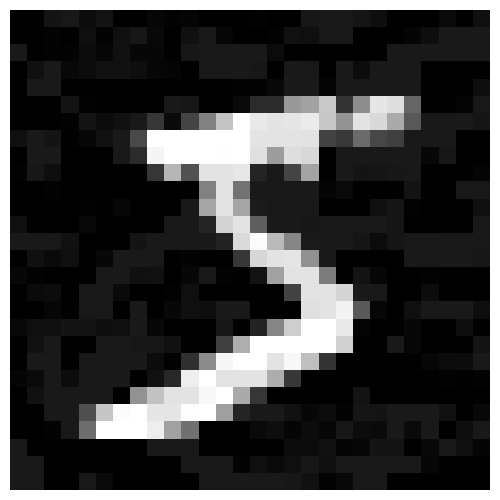

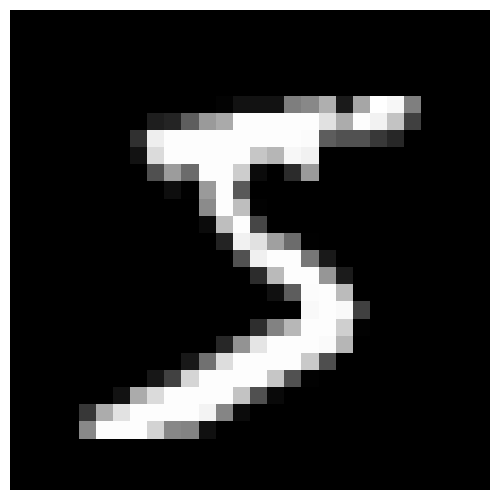

In [21]:
adv = pgd_attack.generate(x_train[:10], batch_size=32)
plot_figure(adv[0], cmap='gray')
plot_figure(x_train[0], cmap='gray')
print(sum(sum(x_train[0] - adv[0])))